In [ ]:
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k, serendipity, diversity, catalog_coverage, distributional_coverage, novelty

In [ ]:
# General libraries
import json
from pathlib import Path as Data_Path
import os
from os.path import isfile, join
import pickle
import random

import numpy as np
import networkx as nx
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline
# Import relevant ML libraries
from typing import Optional, Union

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Embedding, ModuleList, Linear
import torch.nn.functional as F

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch.nn.modules.loss import _Loss

from torch_geometric.nn.conv import LGConv, GATConv, SAGEConv
from torch_geometric.typing import Adj, OptTensor, SparseTensor

print(f"Torch version: {torch.__version__}; Torch-cuda version: {torch.version.cuda}; Torch Geometric version: {torch_geometric.__version__}.")

Loading the model result on full dataset:

In [15]:
lgc_stats_random = pickle.load(open(f"model_stats/LGConv_4_e64_users9514_items937111__BPR_random.pkl", "rb"))

In [16]:
def detach_loss(stats):
  return [loss.detach().cpu().numpy().item() for loss in stats]

def plot_train_val_loss(stats_dict):
  fig, ax = plt.subplots(1,1, figsize = (6, 4))
  train_loss = detach_loss(stats_dict["train"]["loss"])
  val_loss = detach_loss(stats_dict["val"]["loss"])
  idx = np.arange(0, len(train_loss), 1)
  ax.plot(idx, train_loss, label = "train")
  ax.plot(idx, val_loss, label = "val")
  ax.legend()
  plt.show()

Visualization of evaluation metrics: loss, BPR loss, recall at k = 30:

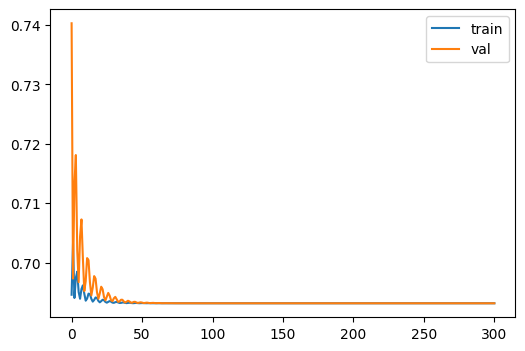

In [17]:
plot_train_val_loss(lgc_stats_random)

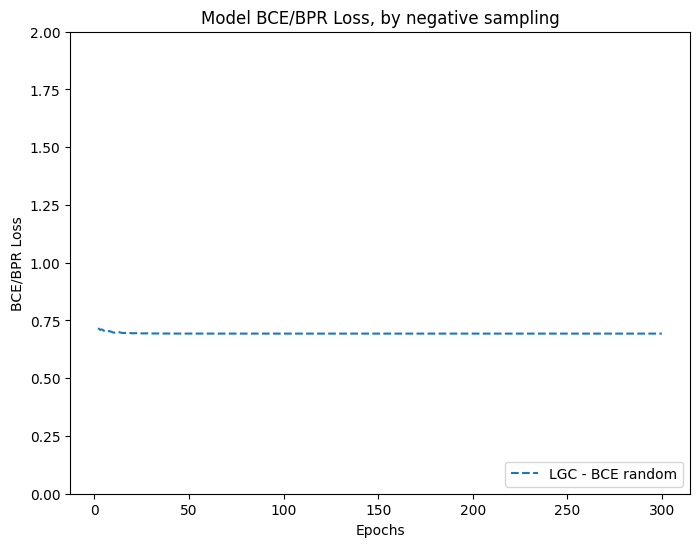

In [18]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
key = "loss"
lgc_loss = pd.Series(detach_loss(lgc_stats_random["val"][key])).rolling(3).mean()
idx = np.arange(0, len(lgc_loss), 1)

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
ax.plot(idx, lgc_loss, color = colors[0], linestyle = 'dashed', label = "LGC - BCE random")
ax.legend(loc = 'lower right')

ax.set_xlabel("Epochs")
ax.set_ylabel("BCE/BPR Loss")
ax.set_title("Model BCE/BPR Loss, by negative sampling")
ax.set_ylim(0, 2)
plt.show()

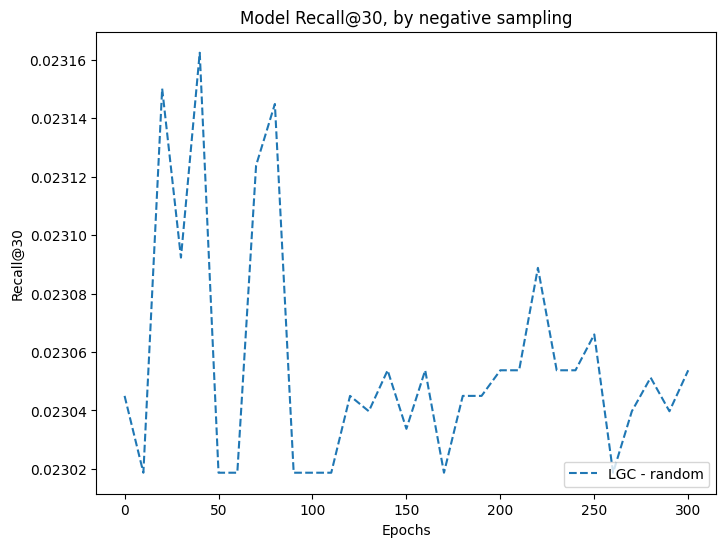

In [19]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
key = "recall"
lgc_recall = lgc_stats_random["val"][key]
# increment by 10
idx = np.arange(0, 10 * len(lgc_recall), 10)

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
ax.plot(idx, lgc_recall, color = colors[0], linestyle = 'dashed', label = "LGC - random")
ax.legend(loc = 'lower right')

ax.set_xlabel("Epochs")
ax.set_ylabel("Recall@30")
ax.set_title("Model Recall@30, by negative sampling")
plt.show()

In [164]:
embedding_path = 'model_stats/LGConv_3_e64_users9514_items937111__embeddings_BPR_random_300_1.pt'
loaded_embeds = torch.load(embedding_path, map_location="cpu")
print(loaded_embeds.keys())

dict_keys(['user_embedding', 'item_embedding'])


In [165]:
loaded_embeds['user_embedding']
loaded_embeds['item_embedding']

Parameter containing:
tensor([[-1.0155e-10, -8.0499e-10,  3.8574e-10,  ...,  4.0182e-10,
          9.7821e-10,  8.9845e-10],
        [-1.1795e-09,  5.7994e-10, -7.4191e-10,  ...,  6.3227e-10,
         -5.4764e-10,  3.4604e-10],
        [ 5.2573e-10,  9.5180e-10,  6.7074e-10,  ..., -4.1567e-10,
         -5.7627e-10, -8.3660e-10],
        ...,
        [-3.4578e-10, -2.7906e-10,  8.3629e-10,  ...,  5.4815e-10,
          7.6332e-10,  6.8021e-10],
        [-1.7165e-11, -2.0900e-10,  9.7085e-10,  ..., -1.3172e-10,
          4.7067e-10, -5.7002e-10],
        [ 6.3614e-10, -7.1980e-10,  3.9812e-10,  ..., -8.9436e-10,
          6.7027e-10, -5.3798e-10]], requires_grad=True)

In [24]:
# set the seed for reproducibility
seed = 224
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [25]:
user_song_data = pd.read_csv('../Data/user_songs_filtered.csv')
song_song_data = pd.read_csv('../Data/songs_with_similarities_final.csv')
user_song_data = user_song_data.sort_values(by = 'Username')
user_song_data = user_song_data.reset_index(drop=True)

In [118]:
class Track:
  def __init__(self, track_name, artist_name, similar_tracks):
    self.name = track_name
    self.artist_name = artist_name
    self.similar_tracks = similar_tracks


  def __str__(self):
    return f"Track called {self.name} from artist {self.artist_name}."

  def __repr__(self):
    return f"Track {self.name}"

user_song_data[['track_name', 'artist_name']].drop_duplicates().to_numpy()

tracks = []
unique_tracks = user_song_data[['track_name', 'artist_name']].drop_duplicates().to_numpy()

for track, artist_name in unique_tracks:
    row_similar_songs = song_song_data[(song_song_data['track_name'] == track) & (song_song_data['artist_name'] == artist_name)].iloc[0]
    similar_tracks = [
        (row_similar_songs['Track_Name_1'], row_similar_songs['Similarity_1'], row_similar_songs['Artist_Name_1']),
        (row_similar_songs['Track_Name_2'], row_similar_songs['Similarity_2'], row_similar_songs['Artist_Name_2']),
        (row_similar_songs['Track_Name_3'], row_similar_songs['Similarity_3'], row_similar_songs['Artist_Name_3']),
        (row_similar_songs['Track_Name_4'], row_similar_songs['Similarity_4'], row_similar_songs['Artist_Name_4']),
        (row_similar_songs['Track_Name_5'], row_similar_songs['Similarity_5'], row_similar_songs['Artist_Name_5'])
    ]

    for similar_track in similar_tracks:
      tracks += [Track(similar_track[0], similar_track[2], [])]


    tracks += [Track(track, artist_name, similar_tracks)]


class User:
  def __init__(self, user_data, top_songs):

    self.name = user_data['Username']
    self.country = user_data['country']
    self.track_count = int(user_data['track_count'])
    self.total_playcount = 0
    self.top_songs = {}
    self.artists = []
    for index, row in top_songs.iterrows():
      rank = row['rank']
      track_name = row['track_name']
      artist_name = row['artist_name']
      track = [obj for obj in tracks if (obj.name == track_name)&(obj.artist_name == artist_name)][0]
      playcount = row['playcount']
      self.top_songs[rank] = (track, playcount)
      self.total_playcount += playcount
      self.artists += [artist_name]

    self.top_songs =  {k: self.top_songs[k] for k in sorted(self.top_songs)}
  def __str__(self):
    return f"User {self.name} with {len(self.top_songs)} top tracks loaded, total listen count is {self.total_playcount}."

  def __repr__(self):
    return f"User {self.name}"
  def __lt__(self, other):
    return (self.name < other.name) and (self.total_playcount < other.total_playcount)

  def __gt__(self, other):
    return (self.name > other.name) and (self.total_playcount > other.total_playcount)

unique_users = user_song_data.Username.unique()
users = []
for user in unique_users:
    user_data = user_song_data.loc[user_song_data['Username'] == user].iloc[0]
    user_data = user_data[['Username', 'country', 'track_count']].to_dict()
    top_songs = user_song_data.loc[user_song_data['Username'] == user]
    top_songs = top_songs[['rank', 'track_name', 'artist_name', 'playcount']]
    users +=[User(user_data, top_songs)]



In [177]:
# adding nodes
G = nx.Graph()
G.add_nodes_from([
    (p, {'name':p, "node_type" : "user"}) for p in users
])
for track in tracks:
    G.add_node(track, node_type="track")
    if (len(track.similar_tracks) == 5):
        for similar_track in track.similar_tracks:
            G.add_node(similar_track, node_type="track")


n_nodes, n_edges = G.number_of_nodes(), G.number_of_edges()

# by sorting them we get an ordering playlist1, ..., playlistN, track1, ..., trackN
sorted_nodes = [node for node in G.nodes()]
# sorted(sorted_nodes)

# create dictionaries to index to 0 to n_nodes, will be necessary for when we are using tensors
node2id = {key: value for key, value in zip(sorted_nodes, np.arange(n_nodes))}
id2node = {value: key for value, key in zip(np.arange(n_nodes), sorted_nodes)}


# Add edges

for user in users:
  top_songs = user.top_songs
  user_total_listening = user.total_playcount
  for song, count in top_songs.values():
      G.add_edge(node2id[user], node2id[song], weight= (count/user_total_listening))

for track in tracks:
    for similar_track in track.similar_tracks:
        G.add_edge(node2id[track], node2id[similar_track], weight = similar_track[1])

G = nx.relabel_nodes(G, node2id)

# also keep track of how many users, tracks we have
users_idx = [i for i, v in enumerate(node2id.keys()) if isinstance(v, User)] 
tracks_idx = [i for i, v in enumerate(node2id.keys()) if isinstance(v, Track)]

n_users = np.max(users_idx) + 1
n_tracks = n_nodes - n_users

# Relabel nodes to have consecutive integer indices starting from 0
node_mapping = {node: idx for idx, node in enumerate(G.nodes())}

# Relabel the nodes in the graph using the mapping
G = nx.relabel_nodes(G, node_mapping)

edge_lst = [edge for edge in G.edges]

# Get the edge indices from the relabeled graph
edge_idx = torch.tensor(edge_lst).t()


# Get the edge weights from the NetworkX graph
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
edge_weights = torch.tensor(edge_weights, dtype=torch.float)

# Create the PyTorch Geometric Data object
num_nodes = len(G.nodes())
graph_data = Data(edge_index=edge_idx, edge_weight=edge_weights, num_nodes=num_nodes)

# Get the edge indices from the relabeled graph
edge_idx = torch.tensor(edge_lst).t()

# Get the edge weights from the NetworkX graph
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
edge_weights = torch.tensor(edge_weights, dtype=torch.float)

# Create the PyTorch Geometric Data object
num_nodes = len(G.nodes())
graph_data = Data(edge_index=edge_idx, edge_weight=edge_weights, num_nodes=num_nodes)


In [178]:
transform = RandomLinkSplit(
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=0,
    num_val=0.15, num_test=0.15
)

train_split, val_split, test_split = transform(graph_data)


# Edge index: message passing edges
train_split.edge_index = train_split.edge_index.type(torch.int64)
val_split.edge_index = val_split.edge_index.type(torch.int64)
test_split.edge_index = test_split.edge_index.type(torch.int64)
# Edge label index: supervision edges
train_split.edge_label_index = train_split.edge_label_index.type(torch.int64)
val_split.edge_label_index = val_split.edge_label_index.type(torch.int64)
test_split.edge_label_index = test_split.edge_label_index.type(torch.int64)

print(f"Train set has {train_split.edge_label_index.shape[1]} positives supervision edges")
print(f"Validation set has {val_split.edge_label_index.shape[1]} positive supervision edges")
print(f"Test set has {test_split.edge_label_index.shape[1]} positive supervision edges")

print(f"Train set has {train_split.edge_index.shape[1]} message passing edges")
print(f"Validation set has {val_split.edge_index.shape[1]} message passing edges")
print(f"Test set has {test_split.edge_index.shape[1]} message passing edges")

Train set has 471498 positives supervision edges
Validation set has 101034 positive supervision edges
Test set has 101034 positive supervision edges
Train set has 942996 message passing edges
Validation set has 942996 message passing edges
Test set has 1145064 message passing edges


In [166]:
user_embeddings = loaded_embeds['user_embedding']
tracks_embeddings = loaded_embeds['item_embedding']

In [196]:
print("Max user index in train:", max(train_split.edge_label_index[0]))
print("Max track index in train before adjustment:", max(train_split.edge_label_index[1]))
print("Min track index in train before adjustment:", min(train_split.edge_label_index[1]))

print(n_users)
print(n_tracks)

# Adjust train and test indices for items
train_users, train_items = train_split.edge_label_index[0], train_split.edge_label_index[1] - n_users
train_items = torch.clamp(train_items, 0, n_tracks-1)  # Ensure indices are within valid range
train_users = torch.clamp(train_items, 0, n_users - 1)

print("Max track index in train after adjustment:", max(train_items))
print("Min track index in train after adjustment:", min(train_items))

print("Max user index in train after adjustment:", max(train_users))
print("Min user index in train after adjustment:", min(train_users))

Max user index in train: tensor(946619)
Max track index in train before adjustment: tensor(946624)
Min track index in train before adjustment: tensor(9514)
9514
937111
Max track index in train after adjustment: tensor(937110)
Min track index in train after adjustment: tensor(0)
Max user index in train after adjustment: tensor(9513)
Min user index in train after adjustment: tensor(0)


Computation of relevance score:

In [197]:
relevance_score = torch.matmul(user_embeddings, tracks_embeddings.T)

Getting the top k songs for each user in batches:

In [198]:

def get_metrics(n_users, n_tracks, train_split, test_split, K = 30):
    # Compute relevance score matrix based on user and item embeddings
    
    # Adjust train and test indices for items to ensure they are within range
    # train_users, train_items = train_split.edge_label_index[0], train_split.edge_label_index[1] - n_users
    # train_items = torch.clamp(train_items, 0, n_tracks-1)  # Ensure indices are within valid range
    train_users, train_items = train_split.edge_label_index[0], train_split.edge_label_index[1] - n_users
    train_items = torch.clamp(train_items, 0, n_tracks-1)  # Ensure indices are within valid range
    train_users = torch.clamp(train_users, 0, n_users - 1)

    # Initialize the train mask and apply the infinity mask
    train_mask = torch.zeros(n_users, n_tracks)
    train_mask[train_users, train_items] = float('inf')
    
    # Apply mask
    masked_relevance_score = relevance_score - train_mask

    # Get top-K items for each user in the test set
    topk_values, topk_indices = torch.topk(masked_relevance_score, K, dim=1)

    test = test_split.edge_label_index
    test_data = pd.DataFrame({'user_id_idx': test[0].tolist(), 'item_id_idx': test[1].tolist()})
    test_data.item_id_idx = test_data.item_id_idx.apply(lambda x: x-n_users)

    test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(tuple).reset_index()
    topk_indices_df = pd.DataFrame(topk_indices.numpy(), columns=['topk_idx_' + str(i) for i in range(30)])
    topk_indices_df['user_id_idx'] = [i for i in range(n_users)]

    metrics_df = pd.merge(test_interacted_items, topk_indices_df, on='user_id_idx')
    metrics_df['hit_list'] = metrics_df.apply(lambda row: [1 if idx in row['item_id_idx'] else 0 for idx in row[topk_indices_df.columns[:-1]].values.flatten()], axis=1)

    metrics_df['precision'] = metrics_df['hit_list'].apply(lambda hits: np.mean(hits))

    def calculate_ndcg(row):
        DCG = sum([(2**hit - 1) / np.log2(idx+2) for idx, hit in enumerate(row['hit_list'])])
        IDCG = sum([1 / np.log2(idx+2) for idx in range(min(len(row['item_id_idx']), K))])
        return DCG / IDCG if IDCG > 0 else 0

    metrics_df['ndcg'] = metrics_df.apply(calculate_ndcg, axis=1)

    def calculate_map(row):
        cum_hits = np.cumsum(row['hit_list'])
        precisions = [cum_hits[idx] / (idx + 1) for idx, hit in enumerate(row['hit_list']) if hit]
        return np.mean(precisions) if precisions else 0

    metrics_df['map'] = metrics_df.apply(calculate_map, axis=1)

    return metrics_df[['precision', 'ndcg', 'map']].mean().to_dict()


In [199]:
get_metrics(n_users, n_tracks, train_split, test_split, K = 30)

{'precision': 6.498429546193003e-05,
 'ndcg': 0.0003370646748149671,
 'map': 0.0006351321986885496}

In [138]:
lst = []
for batch_start in range(0, n_users, 64):
    batch_end = min(batch_start + 64, n_users)
    batch_users_embeddings = user_embeddings[batch_start:batch_end]
    scores = torch.matmul(batch_users_embeddings, tracks_embeddings.t())
    mp_indices = ((train_split.edge_index[0] >= batch_start) & (train_split.edge_index[0] < batch_end)).nonzero(as_tuple=True)[0]
    scores[train_split.edge_index[0, mp_indices] - batch_start, train_split.edge_index[1, mp_indices] - n_users] = -float("inf")
    _, top_k_indices = torch.topk(scores, 30, dim=1)

    for i in range(batch_end - batch_start):
        user_id = i + batch_start
        top_k_rec = top_k_indices[i]
        dic = {}
        dic['UserId'] = user_id
        dic['ItemId'] = top_k_rec
        lst += [dic]

In [139]:
ground_truth_edges = train_split.edge_label_index
ground_truth_edges= {'UserId': ground_truth_edges[0], 'ItemId': ground_truth_edges[1]}
ground_truth_edges = pd.DataFrame(ground_truth_edges)

In [140]:
top = pd.DataFrame(lst).explode(column = 'ItemId')
top['ItemId'] = top['ItemId'].astype(int)

Since the diversity library only examines the tracks that are not already in the training data, we will be removing them from the results

In [88]:
top_cleaned = top[~top.isin(ground_truth_edges)].dropna()
top_cleaned['UserId']= top_cleaned['UserId'].astype(int)
top_cleaned['ItemId']= top_cleaned['ItemId'].astype(int)

Diversity:

In [89]:
df_all = top.merge(ground_truth_edges.drop_duplicates(), on=['UserId','ItemId'],
                   how='left', indicator=True)
top_cleaned = df_all.loc[df_all['_merge'] == 'left_only']

In [146]:
ground_truth_edges = train_split.edge_label_index
ground_truth_edges= {'UserId': ground_truth_edges[0], 'ItemId': ground_truth_edges[1]}
ground_truth_edges = pd.DataFrame(ground_truth_edges)
rec_k = pd.DataFrame(dic)
div_args = [ground_truth_edges, top_cleaned]
diversity_eval = diversity(*div_args, col_user="UserId",
    col_item="ItemId")
print(f"Diversity: {diversity_eval}")

Diversity: 0.9999662631580877



We define _catalog coverage_ as the proportion of items showing in all users’ recommendations:
$$
\textrm{CatalogCoverage} = \frac{|N_r|}{|N_t|}
$$
where $N_r$ denotes the set of items in the recommendations (`top_k` in the code below) and $N_t$ the set of items in the historical data (`train`).

_Distributional coverage_ measures how equally different items are recommended to users when a particular recommender system is used.
If  $p(i|R)$ denotes the probability that item $i$ is observed among all recommendation lists, we define distributional coverage as
$$
\textrm{DistributionalCoverage} = -\sum_{i \in N_t} p(i|R) \log_2 p(i)
$$
where
$$
p(i|R) = \frac{|M_r (i)|}{|\textrm{train}|}
$$
and $M_r (i)$ denotes the users who are recommended item $i$.


In [147]:
cov_args = [ground_truth_edges, top_cleaned]
cat_coverage = catalog_coverage(*cov_args, col_user="UserId",
    col_item="ItemId")
dist_coverage = distributional_coverage(*cov_args, col_user="UserId",
    col_item="ItemId")
print(f"Catalog Coverage: {cat_coverage} \nDistributional Coverage: {dist_coverage}")

Catalog Coverage: 0.5301393446885615 
Distributional Coverage: 17.096012627486218


**Novelty**

The novelty of an item is inverse to its _popularity_. If $p(i)$ represents the probability that item $i$ is observed (or known, interacted with etc.) by users, then  
$$
p(i) = \frac{|M_t (i)|} {|\textrm{train}|}
$$
where $M_t (i)$ is the set of users who have interacted with item $i$ in the historical data.

The novelty of an item is then defined as
$$
\textrm{novelty}(i) = -\log_2 p(i)
$$
and the novelty of the recommendations across all users is defined as
$$
\textrm{novelty} = \sum_{i \in N_r} \frac{|M_r (i)|}{|\textrm{top k}|} \textrm{novelty}(i)
$$


In [148]:
nov_args = [ground_truth_edges, top_cleaned]
novelty_eval = novelty(*nov_args, col_user="UserId",
    col_item="ItemId")
print(f"Novelty: {novelty_eval}")

Novelty: 7.345831391927112


**Serendipity**

Serendipity represents the “unusualness” or “surprise” of recommendations. Unlike novelty, serendipity encompasses the semantic content of items and can be imagined as the distance between recommended items and their expected contents (Zhang et al.) Lower cosine similarity indicates lower expectedness and higher serendipity.
We define the expectedness of an unseen item $i$ for user $u$ as the average similarity between every already seen item $j$ in the historical data and $i$:
$$
\textrm{expectedness}(i|u) = \frac{1}{|N_t (u)|} \sum_{j \in N_t (u)} \textrm{Cosine Similarity}(i,j)
$$
The serendipity of item $i$ is (1 - expectedness) multiplied by _relevance_, where relevance indicates whether the item turns out to be liked by the user or not. For example, in a binary scenario, if an item in `top_k` is liked (purchased, clicked) in `train`, its relevance equals one, otherwise it equals zero. Aggregating over all users and items, the overall
serendipity is defined as
$$
\textrm{serendipity} = \frac{1}{|M|} \sum_{u \in M_r}
\frac{1}{|N_r (u)|} \sum_{i \in N_r (u)} \big(1 - \textrm{expectedness}(i|u) \big) \, \textrm{relevance}(i)
$$

In [149]:
ser_args = [ground_truth_edges, top_cleaned]
ser_eval = serendipity(*ser_args, col_user="UserId",
    col_item="ItemId")
print(f"Serendipity: {ser_eval}")

Serendipity: 0.9999809904811929
